In [1]:
using NCDatasets
using Plots, ColorSchemes, LaTeXStrings
using DataFrames, CSV
using SparseArrays, LinearAlgebra

In [45]:
#--------------------------------------------------------------------------------------
# Utility Functions
#--------------------------------------------------------------------------------------

function get_endpoints(ds, vars)

    out = Vector{Any}()

    for v in vars
        append!(out, [ds["$v"][:,:,end]])
    end

    return out[1], out[2], out[3], out[4], out[5]

end

function get_nonzero_axes(M)

    Cs = sparse(M)
    (II, JJ, _) = findnz(Cs) 
    
    return II, JJ

end 

function cut_off(ds, n)

    dss = copy(ds)
    co = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .< co, co, dss[:, i])
    end

    return dss

end

function get_zc(ds, H=890)

    dz = 10
    zc = [dz/2:dz:(H-dz/2)]

    return zc
end

get_zc (generic function with 2 methods)

In [100]:
#--------------------------------------------------------------------------------------
# R* Bacteria on Detritus
#--------------------------------------------------------------------------------------
function get_rstar_B(B, Z, ds, nb, nz, season)
    
    mort_b = b_mortality(B, ds, nb)
    grz_b = b_grazing(B, Z, ds, nb, nz)
    loss_b = b_loss(mort_b, grz_b, nb)
    RstarB_ij = Rstar(loss_b, ds, season)

    return RstarB_ij

end

function b_mortality(B, ds, nb)

    mort_b = Any[]
    for i in range(1, nb)
        push!(mort_b, (ds["m_lb"][i] .+ ds["m_qb"][i] .* B[:,i]))
    end

    return mort_b

end

function b_grazing(B, Z, ds, nb, nz)
    #------- for 1N 4P 3Z 7B 4D
    if nb==7
        GrM = ds["GrM"][:]
        grazing = Any[]
        g_max = 1.0
        K_g = ds["K_g"][3]
        K_g_POM = ds["K_g"][2]

        prey_POM = GrM[2,5]' .*B[:,1]
        gb_POM = g_max .* prey_POM ./ (prey_POM .+ K_g_POM)
        # grz_POM = gb_POM .* Z[:,2] .* GrM[2,5]'  .* B[:,1] ./ prey_POM
        grz_POM = (gb_POM .* Z[:,2] .* GrM[2,5]'  .* B[:,1] ./ prey_POM) ./ B[:,1] 
        push!(grazing, grz_POM)

        prey = GrM[3,6:end]' .*B[:,2:end]
        for i in range(1, 6)
            gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
            # grz_i = gb_i .* Z[:,3] .* GrM[3,i+5]'  .* B[:,i+1] ./ prey[:,i]
            grz_i = (gb_i .* Z[:,3] .* GrM[3,i+5]' ./ prey[:,i]) 
            push!(grazing, grz_i)
        end
    
        return grazing
    
    else

        #----- for 1N 2P 2Z 2B 2D
        if nz == 2
            GrM = ds["GrM"][:]
            grazing = Any[]
            g_max = 1.0
            K_g = ds["K_g"][2]

            prey = GrM[2,3:end]' .*B[:,1:end]
            for i in range(1, nb)
                gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
                grz_i = (gb_i .* Z[:,2] .* GrM[2,i+2]' ./ prey[:,i])
                push!(grazing, grz_i)
            end

        #----- for 1N 1P 3Z 2B 2D
        elseif nz == 3
            GrM = ds["GrM"][:]
            grazing = Any[]
            g_max = 1.0
            K_g = [ds["K_g"][2], ds["K_g"][3]]

            prey = 1.0 .*B[:,1:2]
            for i in range(1, nb)
                gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g[i])
                grz_i = (gb_i .* Z[:,i+1] .* 1.0 ./ prey[:,i]) 
                push!(grazing, grz_i)
            end
        else
        end
    end

    return grazing

end

function b_loss(mortality, grazing, nb)

    loss = Any[]
    for i in range(1, nb)
        push!(loss, mortality[i] .+ grazing[i])
    end

    return loss
end

function get_temp_mod(season)
    #fit to SPOT data (approx 20 to 4, approx 16 to 4)
    if season == "Win"
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/win_temp_mod.csv", DataFrame)
    else
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/sum_temp_mod.csv", DataFrame)
    end

    return Matrix(temp_mod)
end

function Rstar(loss, ds, season)

    vmax_ij = ds["vmax_ij"][:]
    Km_ij = ds["Km_ij"][:]
    yield = ds["y_ij"][:]
    temp_mod = get_temp_mod(season)

    II, JJ = get_nonzero_axes(ds["CM"][:])
    RS = Any[]
    for j = axes(II, 1)
        push!(RS, Km_ij[II[j],JJ[j]] .* loss[j] ./ (yield[II[j],JJ[j]] .* vmax_ij[II[j],JJ[j]] .* temp_mod .- loss[j]))
    end

    for i in range(1, length(RS))
        RS[i] = check_for_negatives(RS[i])
    end

    return RS
end

function check_for_negatives(RS)

    for i in eachindex(RS)
        RS[i] = ifelse(RS[i] < 0, NaN, RS[i])
    end

    return RS

end

function extinct(ds, n)

    dss = copy(ds)
    ex = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .== ex, 0.0, dss[:, i])
    end

    return dss

end

extinct (generic function with 1 method)

In [109]:
#--------------------------------------------------------------------------------------
# Plotting
#--------------------------------------------------------------------------------------
function plot_rstar_2B2D(rstar, D, B, ds, season, np)
    # B1 eats D1 (POM)  |  B2 eats D2 (DOM)  
    # zc = get_zc(ds, 500)
    H = 500
    dz = ds["dz"][:]
    zc = [dz/2:dz:(H-dz/2)]
    lg=:bottomright
    tfs=12
    # lbls = [" \textrm{\; B1}_{R*}", " \textrm{\; POM}", " \textrm{\; B1}", " \textrm{\; B2}_{R*}", " \textrm{\; DOM}", " \textrm{\; B2}" ]

    p1 = plot(rstar[1][1:50], -zc, lw=4, lc="red3", ylabel="Depth (m)", label="", xrotation=45, 
    xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, alpha=0.7)
    plot!(D[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot, alpha=0.7, label=L" D1")

    p2 = plot(rstar[2][1:50], -zc, lw=4, lc="darkorange", label="",xrotation=45, 
    xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""), alpha=0.7)
    plot!(D[1:50, 2], -zc, lw=3, lc="black", linestyle=:dot, alpha=0.7, label=" D2")

    p3 = plot(B[1:50, 1], -zc, lw=4, lc="red3", ylabel="", label=" B1",xrotation=45, 
    xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), alpha=0.7)
    plot!(B[1:50, 2], -zc, lw=4, lc="darkorange", ylabel="", label=" B2", xrotation=45, 
    xguidefontsize=12, border=:box, legend=lg, alpha=0.7)

    combined = plot(p1, p2, p3,
        fg_legend = :transparent,
        fontfamily="Computer Modern",
        layout = (1,3),
        size=(500,400),
        plot_title=L"R* B_D~ \textrm{(%$season)}",
        plot_xlabel=L"mmol/m^3"
    )

    savefig(combined, "/home/lee/Dropbox/Development/NPZBD_1D/results/plots/rstar/rstarB_$(np)P2B2D_$season.png")

    return combined

end

plot_rstar_2B2D (generic function with 1 method)

<h1> 2B2D - Non-competing </h1>

<h3> 1N 2P 2Z 2B 2D </h3>

* Umax_i = [ 1.091275617275966, 3.091275617275966 ]
* Vmax_i = [ 1.00,  2.391054155817703 ]

* Each B grazes its own D pool  - B1 grazes POM and B2 grazes DOM
* One Z grazes all P, and other grazes all B

In [107]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2005.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2301.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

2×4 Matrix{Float64}:
 1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0

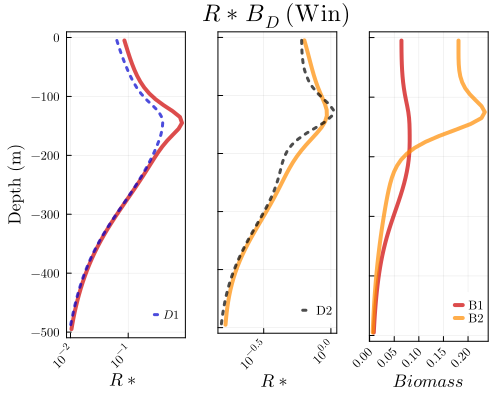

In [110]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
nw, pw, zw, bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
ns, ps, zs, bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

bww = cut_off(bw, 2)
bss = cut_off(bs, 2)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(bww, zw, winter, 2, 2, "Win")
rstarB_ijs = get_rstar_B(bws, zs, summer, 2, 2, "Sum")

bwe = cut_off(bww, 2)
bse = cut_off(bss, 2)

# Plot
plot_rstar_2B2D(rstarB_ijs, Ds, bse, summer, "Sum", 2)
plot_rstar_2B2D(rstarB_ijw, Dw, bwe, winter, "Win", 2)

<h3> 1N 1P 3Z 2B 2D </h3>

* Umax_i = [  2.091275617275966 ]
* Vmax_i = [ 1.00,  2.391054155817703 ]

* Each B grazes its own D pool  - B1 grazes POM and B2 grazes DOM
* One Z grazes P, one POM consumer, one DOM consumer

In [111]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230906_1351.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230906_1413.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

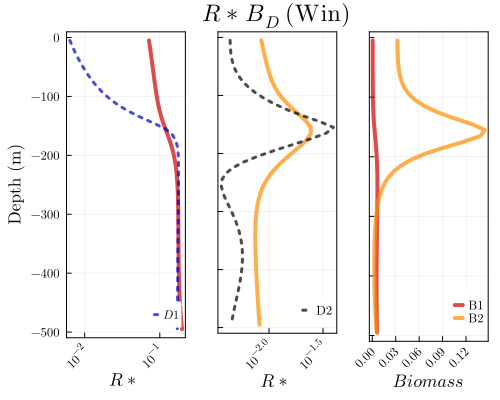

In [112]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
nw, pw, zw, bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
ns, ps, zs, bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

bww = cut_off(bw, 2)
bws = cut_off(bs, 2)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(bww, zw, winter, 2, 3, "Win")
rstarB_ijs = get_rstar_B(bws, zs, summer, 2, 3, "Sum")

bwe = cut_off(bww, 2)
bse = cut_off(bss, 2)

# Plot
plot_rstar_2B2D(rstarB_ijs, Ds, bse, summer, "Sum", 1)
plot_rstar_2B2D(rstarB_ijw, Dw, bwe, winter, "Win", 1)

<h2> For competing B - 7B4D </h2>

In [129]:
using Plots
function plot_rstar_7B4D(rstar_w, rstar_s, Dw, Ds, bw, bs, ds, N)
    # B1 eats D1 (POM)  |  B2 & B7 eat D2  |  B3 & B6 eat D3  |  B4 & B5 eat D4
    # H = ds["H"][:]
    H = 500
    dz = ds["dz"][:]
    zc = [dz/2:dz:(H-dz/2)]

    # yl=(-400.0, 0)
    lg=:bottomright
    tfs=18

    p1 = plot(rstar_w[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10)
    plot!(Dw[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p2 = plot(rstar_w[3][1:50], -zc, lw=4, lc="darkorange", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_w[6][1:50], -zc, lw=4, lc="magenta2",  label="")
    plot!(Dw[1:50, 3], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D3")

    p3 = plot(bw[1:50, 3], -zc, lw=4, lc="darkorange", label=L" B3", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bw[1:50, 6], -zc, lw=4, lc="magenta2",  label=L" B6", alpha=0.8)

    p4 = plot(rstar_w[4][1:50], -zc, lw=4, lc="gold4", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_w[5][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(Dw[1:50, 4], -zc, lw=4, lc="purple", linestyle=:dot, alpha=0.6, label=L" D4")

    p5 = plot(bw[1:50, 4], -zc, lw=4, lc="gold4", label=L" B4", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bw[1:50, 5], -zc, lw=4, lc="lightcyan4", label=L" B5", alpha=0.8)

    #--------------------------------------------------------------------------------------------

    p6 = plot(rstar_s[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10)
    plot!(Ds[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p7 = plot(rstar_s[3][1:50], -zc, lw=4, lc="darkorange", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_s[6][1:50], -zc, lw=4, lc="magenta2", label="")
    plot!(Ds[1:50, 3], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D3")

    p8 = plot(bs[1:50, 3], -zc, lw=4, lc="darkorange", label=L" B3", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bs[1:50, 6], -zc, lw=4, lc="magenta2", label=L" B6", alpha=0.8)

    p9 = plot(rstar_s[4][1:50], -zc, lw=4, lc="gold4", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_s[5][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(Ds[1:50, 4], -zc, lw=4, lc="purple", linestyle=:dot, alpha=0.6, label=L" D4")

    p10 = plot(bs[1:50, 4], -zc, lw=4, lc="gold4", label=L" B4", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bs[1:50, 5], -zc, lw=4, lc="lightcyan4", label=L" B5", alpha=0.8)
    
    
    combined = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10,
        fg_legend = :transparent,
        layout = (2,5),
        size=(900,700),
        # xlabel = "R*",
        # plot_title="Winter", 
        # titlefontsize=tfs, titlelocation=:center, 
    )

    savefig(combined,"/home/lee/Dropbox/Development/NPZBD_1D/results/plots/rstar/rstar_7B4D.png")
    
    return combined

end

plot_rstar_7B4D (generic function with 1 method)

In [130]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230827_1345.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230827_1710.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

4×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0

3×11 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0

In [131]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
Nw, Pw, Zw, Bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
Ns, Ps, Zs, Bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

Bww = cut_off(Bw, 7)
Bss = cut_off(Bs, 7)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(Bww, Zw, winter, 7, 3, "Win")
rstarB_ijs = get_rstar_B(Bss, Zs, summer, 7, 3, "Sum")

Bwe = extinct(Bww, 7)
Bse = extinct(Bss, 7)

89×7 Matrix{Float64}:
 0.0606503   0.0510991   0.0  0.114129    0.0  0.11438     0.0
 0.0607844   0.0510327   0.0  0.114147    0.0  0.114387    0.0
 0.0612363   0.0508295   0.0  0.1143      0.0  0.1145      0.0
 0.0622986   0.0503895   0.0  0.114865    0.0  0.114982    0.0
 0.064311    0.0496209   0.0  0.116304    0.0  0.116281    0.0
 0.0674087   0.0485523   0.0  0.118874    0.0  0.11866     0.0
 0.0710042   0.0475175   0.0  0.121169    0.0  0.120771    0.0
 0.0733587   0.0472491   0.0  0.118428    0.0  0.118004    0.0
 0.0726034   0.0486465   0.0  0.106653    0.0  0.106373    0.0
 0.0684387   0.0522844   0.0  0.0880507   0.0  0.0879651   0.0
 ⋮                                             ⋮           
 0.00774925  0.0013257   0.0  0.00145184  0.0  0.0014135   0.0
 0.0078928   0.00132655  0.0  0.00145422  0.0  0.00141518  0.0
 0.00801881  0.0013272   0.0  0.0014561   0.0  0.00141652  0.0
 0.00812645  0.0013277   0.0  0.00145756  0.0  0.00141754  0.0
 0.00821526  0.00132807  0.0  0.0014

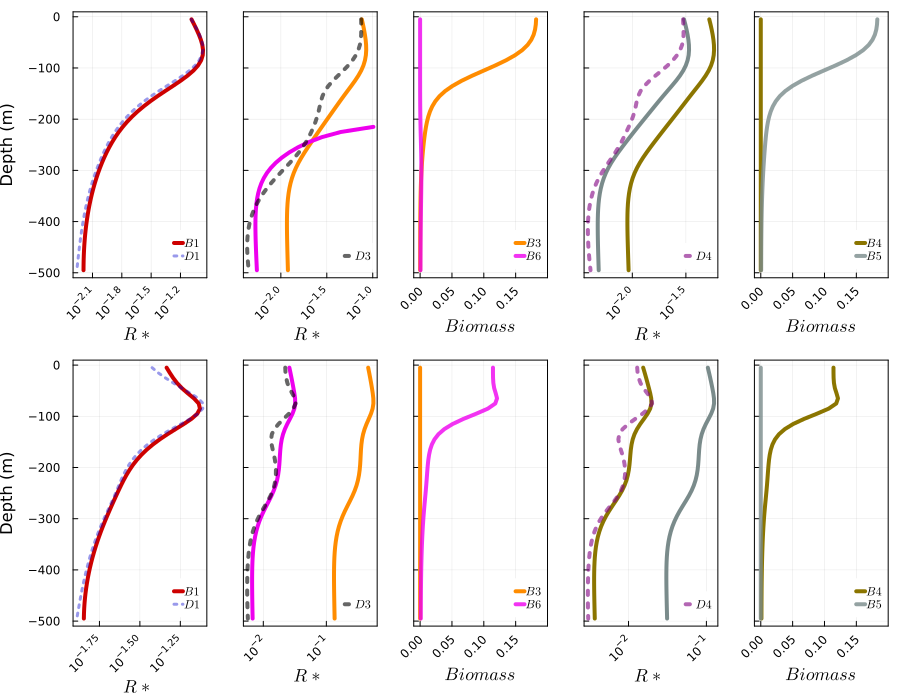

In [132]:
# Plot plot_rstar_7B4D(rstar_w, rstar_s, Dw, Ds, bw, bs, ds, N)
plot_rstar_7B4D(rstarB_ijw, rstarB_ijs, Dw, Ds, Bwe, Bse, winter, 7)

NOTE

* In winter, B3 and B4 'win' and have very similar overall biomass
* B3 and B4 also have very similar relationship to D3 and D4, respectively

* In summer, B6 and B4 
